## 市场宽度
### 显示各个行业的成分股20天乖离率大于0的比例

100%|██████████| 30/30 [05:04<00:00, 10.32s/it]


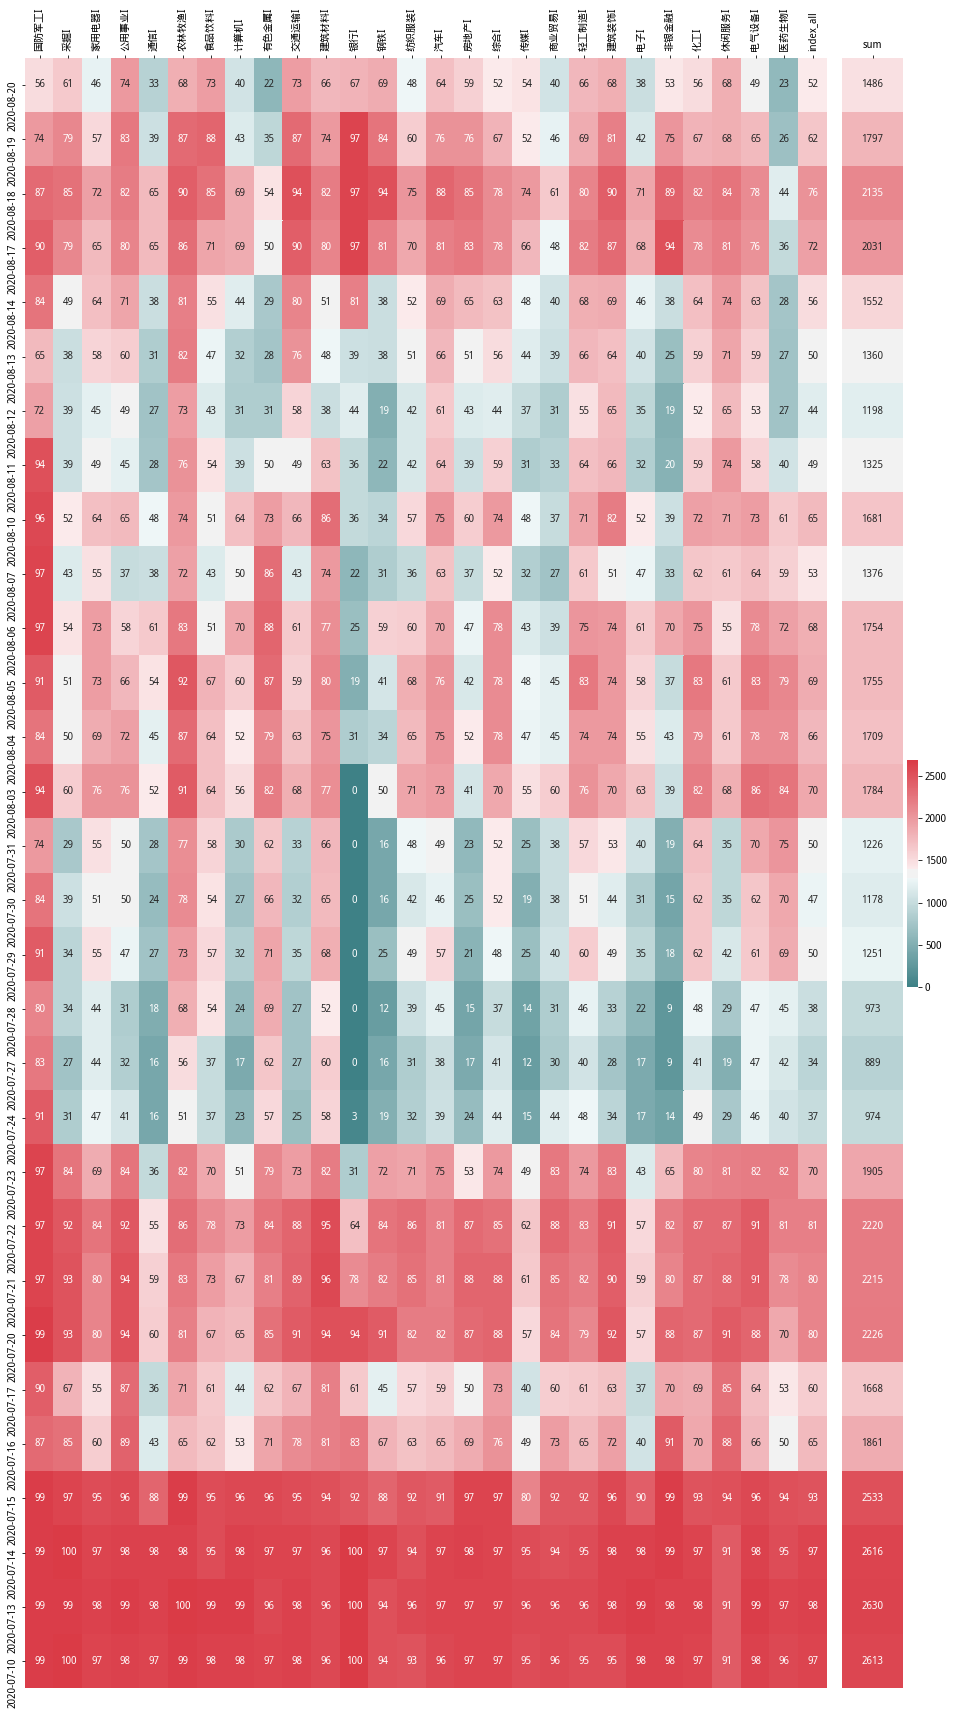

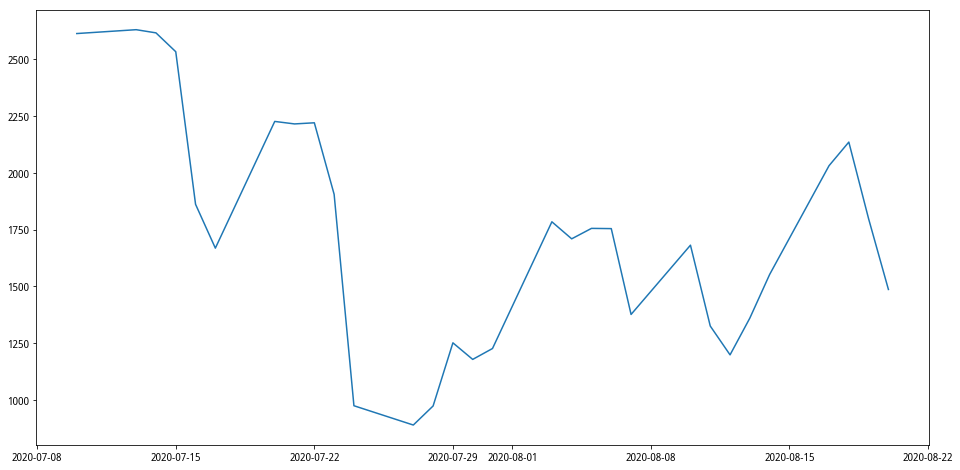

In [30]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/28676
# 标题：市场宽度

from jqdata import *
from jqdata import bond
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tk

import numpy as np
import datetime 
import talib as tb
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore') 
from tqdm import tqdm_notebook # 进度条工具
from tqdm import tqdm
from jqlib.technical_analysis import *
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
#step：获取股票的行业代码
def getStockIndustry(index_stocks_list=[],industries_type="jq_l1",day=None):
    stocks_industry_dict=get_industry(index_stocks_list, date=day)
    stocks_industry_df=pd.DataFrame(stocks_industry_dict).T[[industries_type]]
    stocks_industry_df[industries_type]=stocks_industry_df[industries_type].dropna().apply(lambda x:x['industry_name'])
    return stocks_industry_df[[industries_type]].dropna()


def getStockBIAS(index_stocks_list=[],day=None):
    BIAS1,BIAS2,BIAS3 = BIAS(index_stocks_list,check_date=day, N1=20, N2=60, N3=120,include_now = True, fq_ref_date = None)
    return pd.Series(BIAS1)

#选择指数默认中证流通其他指数见https://www.joinquant.com/help/api/help?name=index
index_='000902.XSHG'
#计算天数
count_=30
#行业分类
industries_type='sw_l1'
# "sw_l1": 申万一级行业
# "jq_l1": 聚宽一级行业


# 行业具体介绍详见
# https://www.joinquant.com/help/api/help?name=plateData


#创建市场容量dataframe
trade_days=get_trade_days(start_date='2010-04-01', end_date=None)[::-1][:count_]
industries_list=get_industries(name=industries_type).name.tolist()
industries_list=[i  for i in industries_list  if i not in ["建筑建材I","机械设备I","交运设备I","信息设备I","金融服务I","信息服务I"]]
market_capacity_day=pd.DataFrame(index=industries_list+["index_all"])



#获取每天的
for day in tqdm(trade_days):
    #step：获取指数成分股
    index_stocks_list=get_index_stocks(index_,date=day)
    stock_df=getStockIndustry(index_stocks_list=index_stocks_list,industries_type=industries_type,day=day)
    
    #step:获取成分股收盘价相对于20日均线位置关系
    stock_df["bias"]=getStockBIAS(index_stocks_list=index_stocks_list,day=day)
    day_market_capacity=(stock_df[stock_df["bias"]>0].groupby(industries_type).count()/stock_df.groupby(industries_type).count())*100

    day_market_capacity.loc["index_all","bias"]=round((len(stock_df[stock_df["bias"]>0])/len(stock_df))*100)
    day_market_capacity["bias"]=day_market_capacity["bias"].fillna(0).apply(lambda x:round(x))
    market_capacity_day[day]=day_market_capacity["bias"]
    
market_capacity_day=market_capacity_day.T
market_capacity_day["sum"]=round(market_capacity_day[industries_list].sum(axis=1))
market_capacity_day=market_capacity_day.fillna(0)
for industry in market_capacity_day.columns:
    market_capacity_day[industry]=market_capacity_day[industry].astype("int32")
    
    
fig=plt.figure(figsize=(16, count_))
grid=plt.GridSpec(1,10)
cmap = sns.diverging_palette(200,10,as_cmap=True)
heatmap1=fig.add_subplot(grid[:,:-1])
heatmap1.xaxis.set_ticks_position('top') 
sns.heatmap(market_capacity_day[market_capacity_day.columns[:-1]],vmin=0, vmax=100, annot=True,fmt="d",cmap=cmap,annot_kws={'size':10},cbar=False)
heatmap2=fig.add_subplot(grid[:,-1])
heatmap2.xaxis.set_ticks_position('top') 
sns.heatmap(market_capacity_day[[market_capacity_day.columns[-1]]],vmin=0, vmax=len(industries_list)*100, annot=True,fmt="d",cmap=cmap,annot_kws={'size':10})

plt.yticks([]) 
plt.show()
plt.style.use({'figure.figsize':(16, 8)})
market_capacity_day["sum"].plot()